In [1]:
import os
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import re
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stoplist = stopwords.words('english')

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

import requests
import json

TF version 2.3.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Markel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Markel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Markel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Markel\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data Analysis

Load data and fill empty rows

In [2]:
train = pd.read_csv('./input/tweet-sentiment-extraction/train.csv')

In [3]:
test = pd.read_csv('./input/tweet-sentiment-extraction/test.csv')

In [4]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Column 'selected_text' is a subset of 'text'

In [5]:
tmp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
tmp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<AxesSubplot:xlabel='sentiment', ylabel='count'>

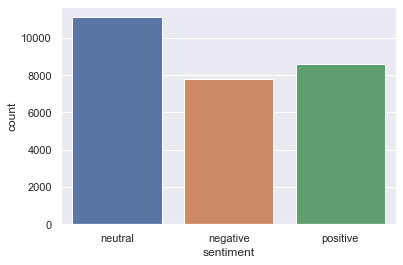

In [6]:
sns.set_theme(style="darkgrid")
sns.countplot(x='sentiment',data=train)

To compare text with selected_text we used **Jaccard**. The way it works is comparing two strings doing the union between them and diveded it by the intersection. The result will be a number between 1 and 0. 1 means the two strings are equals and 0 the two strings are completely different.

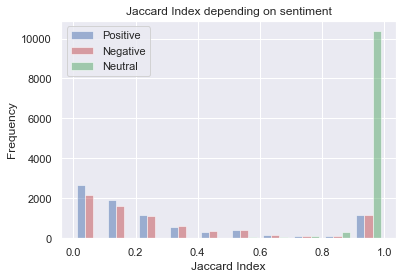

In [7]:
def jaccardIndex(str1,str2): #Get JaccardIndex for two strings
  s1 = set(str1.split())
  s2 = set(str2.split())
  intersect = len(s1 & s2)
  union = len(s1 | s2)
  return intersect / (len(s1) + len(s2) - intersect)

train.dropna(inplace=True) #Drop 'nan' values in dataset

#Apply JaccardIndex function in text and selected_text, creates new column
train['JaccardIndex'] = train.apply(lambda row: jaccardIndex(row.text, row.selected_text) , axis = 1)
jp = train[train['sentiment']=='positive']['JaccardIndex']
jneg = train[train['sentiment']=='negative']['JaccardIndex']
jneu = train[train['sentiment']=='neutral']['JaccardIndex']
#Plotting
plt.hist([jp, jneg, jneu], color=['b','r','g'], alpha=0.5, label=['Positive','Negative','Neutral'])
plt.title('Jaccard Index depending on sentiment')
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [8]:
for index, row in train.iterrows():
    if(len(row['text']) > 0 and row['text'][0]==' ' and row['sentiment'] != 'neutral'):
        print(row['text'])
        print(row['selected_text'])

 Sooo SAD I will miss you here in San Diego!!!
Sooo SAD
 what interview! leave me alone
leave me alone
 Sons of ****, why couldn`t they put them on the releases we already bought
Sons of ****,
 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
Wow... u just became cooler.
 S`ok, trying to plot alternatives as we speak *sigh*
*sigh*
  I`m sorry.
I`m sorry.
 If it is any consolation I got my BMI tested hahaha it says I am obesed  well so much for being unhappy for about 10 minutes.
well so much for being unhappy for about 10 minute
 That`s very funny.  Cute kids.
funny.
 I love to! But I`m only available from 5pm.  and where dear? Would love to help  convert her vids.ï¿½
I love to!
 which case? I got a new one last week and I`m not thrilled at all with mine.
d I`m not thrilled at all with mine.
 it is ****...u have dissappointed me that past few days
it is ****...u have dissappointed me that past few days
 romance zero is funny
romance zero is funny
  He`s awesome... H

 lol i know but it was just so funny, ahaha
funny,
 lol hi emmy, latin would help me study for the aptitude tests to get into grad school ;\ thats why i wanna take it
would help me study for the aptitude tests
 wheres the music mannnn!!?? my inbox is still empty
my inbox is still empty
 ...i`m sorry about you are still sick  u know most of them, AND i know that u will guess the 'pelzer present' ;-)
.i`m sorry
 nice one !
nice
 aah. well, have a few friends over there. Just wondering if all`s great and weather`s been good...
good.
  That was stone cold   Crazy....  ?
That was stone cold   Crazy.
 Already got my ticket; thanks for making sure though!
thanks
 Have a great time in London
great
  Thanks for the greeting
Thanks
 http://twitpic.com/4wb52 - Such a pretty baby!
Such a pretty baby!
 ah, ok  thank youuuuuu!
k  thank
 SherriEShepherd gave the link for  http://www.brentozar.com/twitter. He gives Twitter tips. Hope this helps
. He gives Twitter tips. Hope this helps
 I loved him and

 oh no fair.... thats in 9 hours
no fair.
 anytime love..you looked beautiful! Next time your in nyc, hopefully we can link up! Enjoy your evening
beautiful!
 aww noooo that doesn`t sound too great
that doesn`t sound too great
 I did do that one Twitter while driving, although the iPhone keypad sucks for driving and typing
iPhone keypad sucks
  and what did i do to u kk thanks
k thanks
 aww that`s cute
aww that`s cute
 wow 41,000 now....your really kickin` Carey`s butt with this competition! See you both very soon!
.your really kickin` Carey`s butt with this competition!
 oh dear, hope you are feeling better soon, get some nice hot chicken soup down you.
oh dear, hope you are feeling better soon, get some nice hot chicken soup down you.
 Welcome to Glasgow Felix, sorry I cant be there tonight
, sorry I cant be there tonight
 Im not getting any treatments, we are just gonna hang out at the pool and the hot tubs.
Im not getting any treatments,
 Since you travel quite often and use online

 cant **** wait mate!!! it is goin to fantastic. its made my week
cant **** wait mate!!! it is goin to fantastic.
 Unfortunately, yes...not outside!
Unfortunately,
 oh em i`m sorry  i wuv you to pieces
oh em i`m sorry  i wuv you to pieces
 i`d prefer 'observationally insightful', but call it as you see it.  my ice cream`s just too fancy tonight.
`s just too fancy
 Well thank you! I`ll try and remember to put it somewhere
thank
 I`d just plain go crazy
I`d just plain go crazy
 Where DO you get all those wonderful toys?
Where DO you get all those wonderful toys?
 I heard your moving to Sydney next year im not happy
im not happy
 so glad i`m not at uni anymore
glad
 Oh, sweetie, I`m so sorry.  That`s the last thing you needed right now. *hugs*
w. *hugs*
 Bom dia! FRIOOOO... que delï¿½cia!!!! Good luck in your first day, Ju!
Good luck in your first day, Ju!
 Love to see that!
Love
 meeee too. i am listening to sad music and missing you.  ps - http://www.daytrotter.com/
missing
 Sounds a bi

 Yeah, plus I always totally overspend
Yeah, plus I always totally overspend
 No I LOVE Jordie`s version as well as Joe`s and Donnie`s ALL 3 are DIFFERENT
o I LOVE
 Amazing! The concert, the city, everything. It was really an awesome trip
Amazing! The concert, the city, everything. It was really an awesome trip
 He seemed all happy about it
He seemed all happy about it
 addict? Me? Okay I admit I need help  BUT... I have been writing hits big bro. I really really have *smile*
*smile
 It`s your inherent humility
It`s your inherent humility
 I don`t get as much time here either. It`s going to get worse now that the girls r home for summer.  It stinks.
. It`s going to get worse now that the girls r home for summer.  It stinks.
 All is well..That ends well! < unless of course well times the power of three = the sum of ends if X being All
All is well..That ends well!
 Ooh, cutting. I like you
I like you
 a midwest girl, lol....so close and yet so far
lol....
 No.  I was thinking just before

 pshh. Thanks.
Thanks.
 dammm..i thought i was on to something  lollllll
dammm.
 No, it`s annoying and makes us girls that follow sports and are knowledgable look dumb
No, it`s annoying and makes us girls that follow sports and are knowledgable look dumb
 YES!!! one final party  better make it a good one !! how much mpre stuff you got to go?
a good
 Good Morning my Swedish Friend. I love the Meat Balls.  haha
love
 I want to get all dressed up and go out to, but I to have no one to go with, I`m with you mentor
but I to have no one to go with,
 don`t care about my struggles..
don`t care about my struggles..
 yeah I m so happy for them that they should moved on and out there partying I m so happy
I m so happy
 Thanks mate, just came on board here at Twitter ...  .. tweet up sounds great..
p sounds great.
 I`m running out of things to say, and I`m starting to think you`ll hate me for flooding your inbox with 'Philippines tour?'
hate
 thanks for the message - just worked out how to see the

 I also have a brain tumor called Jeffery.
I also have a brain tumor
 bad times?
bad times?
 We wasnt invited to yall get togethers either! Then  and  was playin security and told us to be quiet!!
We wasnt invited to yall get togethers either! Then  and  was playin security and told us to be quiet!!
 they really do. it is a crying shame.
it is a crying shame.
 Murphy`s Law?  Sorry that your computer is not cooperating when you have lots of work. My kids are .. http://tinyurl.com/km235x
?  Sorry that your computer is not cooperating
 Has to be a Mac! Believe me - you won`t regret it
Has to be a Mac! Believe me - you won`t regret it
 Maatt Havent spoken to you in ages dudeee  Dont forget bout ur Aussie fan  ;) lool. Love ya ****
l. Love
 wow that was easy! Thank you
wow
 tell him ill beat him up if he doesnt share
beat
 Hope that migraine doesn`t stick around for too long.
Hope that migraine doesn`t stick around for too long.
 - I`m alright thanks pal, just bored witless, bored to hell, 

 also, try Friendly Fires if you haven`t already heard them. great stuff  AND Florence and The Machine. Great, great music
. great stuff  AND Florence and The Machine. Great, great music
 Oh! Good idea about putting them on ice cream
Good
 i don`t have any excuse other than night shifts! we got our orphan lambs from a local farmer so we cheated
i don`t have any excuse other than night shifts! we got our orphan lambs from a local farmer so we cheated
 doesnt work already
doesnt work
 http://twitpic.com/4nbx4 - great photo! bravi! we are looking forward for the upcoming pilot in Italy too
great photo!
  that`s the worst dream ever. weird to think all of those thoughts are in your subconscious.
e worst
 i am a bit more curious: how much did you pay for it?
curious:
 i totally owe you a week of on-call duties.  i appreciate not having those while jill is in town
i totally owe you
 it`s a modded 360, so you can`t send it back?  That Red Ring of Death sucks!  It took weeks to get mine back f

 don`t ask  Hoping that today will be an improvment on the rest of the week. Looking forward to the weekend weather!
. Looking forward
 goodnight baby loll jk night
goodnight
 can`t believe i wasn`t following you! am now  have an anatomy prac tmw so tonight i`m all about structr of the lwr limb
can`t believe i wasn`t following you!
 She does especially Pink ones LOL  What beautiful creatures they are!
t beautiful
 amazing tonight glad I could share it with you baby. You are my sunshine
amazing
 phil! I miss you gracin ya with your presence I haven`t been on much  what`s new?
miss
 Are you blogging yet? I miss you writing
miss
 aww  I wish there was sun out here. Then I can get a tan!!!!  (walks it out) go meee go meeee
w  I wish
 thought u said twitter was **** bellion?
****
 good stuff!  I`m great thanks! x
good stuff!
 i have started saving my Tumblr drafts because that happened to me this week and i was so sad
so sad
 thx! i became IBM Master Inventor in 2008. really enjoyed your bl

 yea, I was just about to say something  It`s great to hear! Ukrainian!
s great
 Awww, thank you!  & you`re welcome lol
Awww, thank you!
 you drank it on the sly, didn`t you and that`s why you`re asking. I know how you are
you drank it on the sly,
 ; i think you should come back to brisbane, australia. we loved you here
we loved you here
 I hate snood. lol. sorrry  i dont know how people play it!
sorrry
 The best bike for the best guy! I love the Ducati sound. I think itï¿½s unnecessary to ask for a ride, isnï¿½****? Nice vid ...
best
 Our weekend was also great... two friends of Julia were here for four days...
great.
 hmm, okayy, im really sorry to hear about it  why do you thikn she would have done that? :S
really sorry
 ahh I gtg but pls help me with number 3 I`ll come back later to see what u said  haha plz and thank u
nd thank
 Grrr, people suck. I cry when animals die on nature shows.  These people are sick. No hunting endangered species!
suck.
 hehe true. i wonder what he will 

 so nice to meet you too!  is the best for bringing me along
nice
 well it sounds delicious! i`ll be laying out on my patio tom, sans pool!  Enjoy your burgers!!
delicious!
 haha, yeah i meant mall! -winks back-
-winks back-
 love u!! and love mr. player! come visit me  i miss u girls
love
 Hi Serena just want to say good luck in Madrid and Paris this month
good luck
 yeah...she passed last week.  so sad!
yeah...she passed last week.  so sad!
  i just want to wish your mom a happy mothers day!
a happy mothers day!
 thank you for the re-tweet
thank you for the re-tweet
 hey we were doing the same thing this weekend! but it was for the kiddos...gotta love ikea
..gotta love ikea
 whoa... if the alcohol won`t get you buzzed... the price will
whoa... if the alcohol won`t get you buzzed... the price will
 Great stuff, can`t wait to hear it!
Great
 Hi Mel, if you feel unhappy just take a bit of fries but don`t overdo.  If can help it don`t
unhappy
 Haha of course! That`s my favorite album of 

 http://twitpic.com/4i3g6 - i love that game  xxxx
i love that game
 lol thanks.  I do like to be on top. I`m going to enjoy this. How long can I be up there?
o enjoy
 I`m excited! Hust let me know when you want to go over to Lucky7 Tattoos
excited!
 correct! I ADORE him. I just plucked him up and put him under my arm cuz he was cryin.  All better now! Hahaha
ADORE
 not working here
not working here
 MC, happy mother`s day to your mom ;).. love yah
MC, happy mother`s day to your mom ;).. love yah
 i sorry sweetpea... almost over with!
sorry
 Tis a book...called Love, **** and Tragedy. Highly interesting. Influence of classical on modern world
Highly interesting.
 i think i hate you.  i didnt really want to but you make it hard for me to like you what with the cake and concert on the  ...
t you make it hard for me
 Sorry to hear that Carol.
Sorry to hear that Carol.
 ze Franz has not friended me  i think they think i`m a creepy stalker or sommat. Hmph.
k they think i`m a creepy stalker 

 Well, all I can do, is pray for you.....
, is pray for you....
 like cheesecake brownies!!! i miss my cheesecake brownies... and the walmart closest to l.a. (to me) doesn`t have em
miss
 Anything for . So sorry man  I am not a patsy generally...
sorry
 Oh wow they are really good  I think Im going to use one of them lol.
Oh wow they are really good  I think Im going to use one of them lol.
 lol very much appreciated!!!  so excited!!!
appreciated!
 night honey..see ya tomorrow
night honey..see ya tomorrow
 Im glad you`re a lot happier barakitten  <3 see yah in july
Im glad
 we did! They came out cold  The cheese sauce was good, though.
They came out cold  The cheese sauce was good, though.
 Love that song! Happy Monday
Love that song! Happy Monday
 OMG i want to go too!  hahaha
OMG i want to go too!  hahaha
 The ball is in motion. I have to type up concepts in outline format we could develop those to ensure we deliver greatness
develop
 Hey never realized that you also get a Twitter ac

heat will be too much,
 nope no love
no love
 Nothing wrong with that samantha
Nothing wrong
 I don`t think  will want to come back  (guys read your dms)
I don`t think  will want to come back
  oh man i wanna be in the bay asap! Thank you   Have a great day!
ve a gre
 Maybe it had a hot date with a nice little Cesna.
nice
 Haha dude, we have the same b-date :p I`ll wish u ur b-day the 3oth November. I`ll also turn 16  Can u reply to me please ?
wish
 Loads of Beard papas have disappeared in the UK too
disappeared
 very familiar.....sorry you`re feeling that way
.sorry
 a great song by East Clubbers
great
  cool  you are here too  hi sam  how are you???
cool
 don`t you just love the 'butteflies in your stomach' feeling?  ano man yun, kaya mo yan.
'butteflies in your stomach'
 Excellent pic! Wish I were there, but it`s a long drive from TN.
Excellent
 I have no IPhone (poor credit!).    But I cannot live without my cell phone! I am on mass transit every day!
(poor
 Aw  yes we had it out 

 I did?!  yay! Where did I get that extra ï¿½300 from? Hmm.. anyway  I`m going to be partying hard when I get it
yay!
 yea, feel like im bein ignored
ignored
 thank you Jonas
thank you
 ur really the sweetest person ever! thanks for making everyone`s dreams come true..(p.s) my dream is for u 2twitter me back  x
ur really the sweetest person ever!
 I`m going to ask Waldi. I hope he makes a new keyword for me
hope
 i wish i could find my camera cause i really wanna record some too...
wish
 you`re a big man for embracing your tears
you`re a big man for embracing your tears
 Hey guys! can i ask; what item did u guys put up for ur talent show? i am such a BIG fans of both of you! whoo!
fans
 Awwwwwww. You two are the cutest.  And gods, I LOVE your hair.
I LOVE
 Did you see my message mandingo jr.!!..lol. I hope its music i`ll like.
.lol. I hope its music i`ll like.
 ohhh ok. so like, it`s more frustrating? I had my hands on a 3g iphone last week but it was upgraded so i couldn`t unlock it
f

ll doesnt deserv
 Oh aye.....he rocks, shes ****
rocks,
 hahahaha! i haven`t been out with my friends since sunday! i`m so lame
i`m so lame
 suck it up
suck it up
 what`s going on sweetheart?
what`s going on sweetheart?
 weird trigger. You should definitely ask him about them on monday, dude...  ****.
weird
  boo. I used to live in upland... Have funnnn
e funnnn
 am I not good enough
not good enough
 Knight...sweet dreams.
.sweet dreams.
 keep telling yourself you`ll feel better by doing it and tomorrow can be a lazy day... it is Sunfay afterall  (Excuses.)
keep telling yourself you`ll feel better by doing it and tomorrow can be a lazy day... it is Sunfay afterall
 Yeah, I know! Thanks so much
Thanks
 Hi Susan, read your blog.  It`s really good.  I look forward for the tweet updates
y good
 thats not really fair. I mean you just up and leave like that and you dont even give us a party  So when you coming back or  ...
not really fair.
  that`s bad luck!
that`s bad luck!
 Listened to it 

 Thanks for the reminder Tony
Thanks
 heyyy girl.. havent tweeted u all week. hope all is well with you
hope
 Nofair! My BK only had Uhura and Nero left.
Nofair!
 Yeah. Me too. Will lookout on your tweets too. Happy Tweeting
Happy Tweeting
 good catch!  Thanks a bunch- have to put up a new widget.
good catch!
 ... much more injustice than we can imagine now. It will get worse before it gets better, I am afraid. No doubt here. Sorry
much more injustice than we can imagine now. It will get worse before it gets better, I am afraid. No doubt here. Sorry
  That is really sad
That is really sad
 IIII know!!! and mean
IIII know!!! and mean
 You`re right- you don`t do sympathy very well
you don`t do sympathy very well
 Ha-ha abbreviate it , so it`s not so bulky
bulky
 yearling in pet home died... very sad for their whole family
yearling in pet home died... very sad for their whole family
 aw thank you sam phil, i love you
thank
 you are a slow answerer!
slow answerer!
 WOw, that`s a lot of wor

 http://twitpic.com/4j585 - HAHA nice, now I need an iPhone
A nice,
 Congrat on 4AM. I do it every day since one month.
Congrat
 nah the lights killed the mood now you got to get out my bed
the lights killed the mood
 nooo it was a real mushroom! but our neighbor uprooted it
uprooted
 I hope the young`ins enjoyed your wisdom!
I hope
 Aha both same length, touche
touche
 Dang me too! It`s only a 4 hour drive! Too bad it`s my daughters 1st bday party  it`s hosted by Donnie
Too bad
 sounds like a plan.....yea excited now
excited
 !!!!  glad you`re alright!
glad you`re alright!
 good luck chan! gue kmrn bawa backpack kosong, quite helping
good luck chan!
 hey Bow when yu comin baxx 2 thaa 614 we miss yu hun  ...614 all day!!
we miss yu
 Yeah, I remember.  *hugs*
*hugs
 sadly, I don`t   hehe
sadly,
 I loved it! You guys are amazing!
I loved it!
 baaha  & healthy choice my friend! (:
& healthy choice
 that video was funny  i`m just signing up now and i`ll vote for you!!  x
funny
 nice song, 

# Data Augmentation

Data Augmentation is quite easy to get for images, but how about when dealing with natural language?

Several methods can be applied for NLP data augmentation, such as backtranslating, synonym replacement, random insertion, random deletion...

In this section the synonym replacement technique is used

Unfortunately this augmented dataset yields worse results, so it is not used.

In [9]:
def get_synonyms(word):
    url = "http://paraphrase.org/api/en/search/"
    synonyms = []
    querystring = {"batchNumber":"0","needsPOSList":"true","q":word}
    
    res = requests.request("GET", url, params=querystring)
    res_json = res.json()
    
    count = res_json['hits']['found']
    if count > 0:
        count = min(3, count )
        hits = res_json['hits']['hit'][:count]
        synonyms = [ hit['target'] for hit in hits]
    return synonyms

Example of use

In [10]:
get_synonyms('bad')  

['wrong', 'poor', 'terrible']

In [11]:
vader = SentimentIntensityAnalyzer()

def sort_by_len(lst): 
    lst.sort(key=len) 
    return lst 

In [12]:
def find_synonym( text, selected_text, sentiment):
    
    selected_texts = []
    texts = []
    
    orig_words = selected_text.split()
    words = [ word_tokenize(str(word)) for word in orig_words]
    words = [ word[0] for word in words if len(word) > 0]

    polar_words = []
    if sentiment == 'positive':
        polar_words = [ word for word in words if vader.polarity_scores(word)['pos'] > 0]
    elif sentiment == 'negative':
        polar_words = [ word for word in words if vader.polarity_scores(word)['neg'] > 0]

    if len(polar_words) == 0:
        b=orig_words[0]
        b=re.sub(r'\W+','',b).lower()
        for word in orig_words:
            if(len(word)>len(b)):
                b=word
        polar_words = [b]
 
    polar_word = sort_by_len(polar_words)[-1]

    try:        
        similar_words = get_synonyms(polar_word) 
        
        for similar in similar_words:
            selected_texts.append(re.sub(polar_word,similar,selected_text))
            texts.append(re.sub(polar_word,similar,text))
        
    except Exception as e:
        print(e)
        if texts == [] and selected_texts == []:
            return ('','')
            
    return (texts,selected_texts)

Example of use

In [13]:
find_synonym("You are so disgusting", "disgusting", "negative")

(['You are so totally disgusting',
  'You are so really disgusting',
  'You are so disgusting , okay'],
 ['totally disgusting', 'really disgusting', 'disgusting , okay'])

Generating the augmented dataset

In [14]:
# generated = train.progress_apply(lambda x : find_synonym(x.text,x.selected_text, x.sentiment),axis=1)
# x,y = list(map(list,zip(*generated.values.tolist())))

# train_aug=pd.DataFrame({"textID": train.textID.values,"text":x,"sentiment":train.sentiment.values,'selected_text':y})
# train_aug.to_csv('twitter_augmented.csv',index=False)
# train_aug.head()

# Tokenize Train Data

In [15]:
MAX_LEN = 96
PATH = './input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In the dataset there are some predictions that break consecutive interrogations, exclamations and ellipses, but roBERTa treats these as single tokens. Therefore it is necessary to split them to permit these predictions.

Auxiliary functions to split ellipses, exclamations and interrogations

In [16]:
def addPoint(ids,tokens):
    ids.append(4)
    tokens.append('.')
    
def addExclamation(ids,tokens):
    ids.append(328)
    tokens.append('!')
    
def addInterrogration(ids,tokens):
    ids.append(116)
    tokens.append('?')

def splitEnc(enc):
    ids = []
    tokens = []
    for i in range(len(enc.tokens)):
        if enc.ids[i] == 7586:
            [addPoint(ids,tokens) for i in range(0,2)]
        elif enc.ids[i] == 734:
            [addPoint(ids,tokens) for i in range(0,3)]
        elif enc.ids[i] == 28749:
            [addInterrogration(ids,tokens) for i in range(0,2)]
        elif enc.ids[i] == 38713:
            [addInterrogration(ids,tokens) for i in range(0,3)]
        elif enc.ids[i] == 12846:
            [addExclamation(ids,tokens) for i in range(0,2)]
        elif enc.ids[i] == 16506:
            [addExclamation(ids,tokens) for i in range(0,3)]
        else:
            ids.append(enc.ids[i])
            tokens.append(enc.tokens[i])
    return ids,tokens

In this step we tokenize, or prepare for the input data so that it can be fed to the model

In [17]:
train = pd.read_csv('./input/tweet-sentiment-extraction/train.csv').fillna('')
test = pd.read_csv('./input/tweet-sentiment-extraction/test.csv').fillna('')

In [18]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
    ids,tokens = splitEnc(enc)
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(ids)+5] = [0] + ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

# Tokenize Test Data

In [19]:
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)
    ids,tokens = splitEnc(enc)
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(ids)+5] = [0] + ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(ids)+5] = 1

# Build roBERTa model

In [20]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)
    
    
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [21]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Decaying learning rate. 0.705 -> 0.70878

In [22]:
def lrfn(epoch):
    dd = {0:4e-5,1:2e-5,2:1e-5,3:5e-6,4:2.5e-6}
    return dd[epoch]

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
    
    lr = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv, lr],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            ids,tokens = splitEnc(enc)
            st = tokenizer.decode(ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################


All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./input/tf-roberta/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

In [ ]:
print(test)

# Apply Post processing

In [ ]:
#p=prediction, t=text, ex=sentiment
def postprocessing(p,t,s):
    t_l = t.lower()
    p_l = p.lower()
    
    # clean prediction
    b = 0
    if len(p_l)>=1:
        if p_l[0]==' ': 
            b = 1
            p_l = p_l[1:]
    x = t_l.find(p_l)
    
    # Prediction has to be a subset of text, like selected_text
    if x==-1:
        return p
    
    # Adjust extra space
    p = np.sum( np.array(t_l[:x].split(' '))=='' )
    if (p>2): 
        d = 0; f = 0
        if p>3: 
            d=p-3
        return t_l[x-1-b-d:x+len(p_l)]

    # Clean wrong predictions
    if (len(p_l)<=2)|(s=='neutral'):
        return t_l

    return p

# Kaggle Submission

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        ids,tokens = splitEnc(enc)
        st = tokenizer.decode(ids[a-1:b])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

In [ ]:
for i in range(len(test)) :
    test.loc[i, "selected_text"] = postprocessing(test.loc[i, "selected_text"], test.loc[i, "text"], test.loc[i, "sentiment"])

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)